### single label classification transformers


In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# CUDA_VISIBLE_DEVICES options = 0/1/2,3. Make sure to restart
!echo $AVAILABLE_CUDA_DEVICES

In [2]:
# !pip install spacy
# !pip install nltk

import os
import time
import glob
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# pytorch libraries
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from keras.preprocessing.sequence import pad_sequences
from transformers import *
from tqdm import tqdm, trange
import pickle
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


In [3]:
# configs
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT, 'data')
os.makedirs(data_dir, exist_ok=True)
print("Data dir: ", data_dir)

sheet_name = "Sheet1" # find your sheet name at the bottom left of your excel file
train_filename1 = os.path.join(data_dir, '1658846255_validation.xlsx') 
df1 = pd.read_excel(train_filename1, sheet_name = sheet_name)

sheet_name = "Nike"
train_filename2 = os.path.join(data_dir, 'Additional_Intents_Data.xlsx') 
df2 = pd.read_excel(train_filename2, sheet_name = sheet_name)

sheet_name = "Sheet1"
train_filename3 = os.path.join(data_dir, 'final_Retail.xlsx') 
df3 = pd.read_excel(train_filename3, sheet_name = sheet_name)

# # all files
# files_xlsx = glob.glob(data_dir + '/With_intent_categories_merged/*.xlsx', recursive=True)
# df = pd.concat([pd.read_excel(file, sheet_name) for file in files_xlsx], ignore_index=True)
# df.to_csv("combined_intent_file.csv")


Data dir:  /home/DATA/amit_kesari/IntentClassification/data


In [5]:
# check the three dataframes
print(df1.shape, df2.shape, df3.shape)

df1.head()
df2.head()
df3.head()


(6235, 45) (702, 2) (180935, 10)


,subject,property,score,subject_begin,subject_end,property_begin,property_end,category_oc_name,category_noc_name,document_content
0,card: 4013,card: 4013,5,0,10,0,10,*Others*,*Information*,card: 4013 zip: 31698 genesis acevedo Aqua ma...
1,A/C R6258579,A/C R6258579,5,65,77,65,77,*Others*,*Information*,Hello I received a statement today for deliver...
2,ac 2983089-7,ac 2983089-7,5,0,12,0,12,*Others*,*Information*,ac 2983089-7 Fed up off paying £3.99 delivery ...
3,acc 27996037,acc 27996037,5,226,238,226,238,*Others*,*Information*,I have happy chickens again! My order arrived😎...
4,Acc A0697738,Acc A0697738,5,268,280,268,280,*Others*,*Information*,FAO Ben Hi my sister has talked to you regardi...


In [6]:
# change dataframe to only two columns
document_columns = ['DOCUMENT_CONTENT', 'DOCUMENT_CLASS']

new_df1 = df1[['Message', 'DOCUMENT_CLASS']]
new_df2 = df2[['DOCUMENT_CONTENT', 'DOCUMENT_CLASS']]
new_df3 = df3[['document_content','category_oc_name']]

new_df1.set_axis(document_columns, axis='columns', inplace=True)
new_df2.set_axis(document_columns, axis='columns', inplace=True)
new_df3.set_axis(document_columns, axis='columns', inplace=True)
new_df1.head()


,DOCUMENT_CONTENT,DOCUMENT_CLASS
0,cant access my account,Account
1,pls clear my account on,Account
2,i cant access my account,Account
3,i cant get on my account,Account
4,why cant i have anaccount,Account


In [8]:
# combine the three dataframes into one
df = pd.concat([new_df1, new_df2, new_df3])
print("Shape: ", df.shape)
if df.isnull().values.any():
    # Earlier Shape:  (187872, 2)
    print('Null values found rows: ',df[df['DOCUMENT_CONTENT'].isnull()].index.tolist())
    print("Dropping...")
    df.dropna(subset = ['DOCUMENT_CONTENT'], inplace=True)

print('Average sentence length: ', df['DOCUMENT_CONTENT'].str.split().str.len().mean())
print('Std deviation sentence length: ', df['DOCUMENT_CONTENT'].str.split().str.len().std())

df

Shape:  (187872, 2)
Null values found rows:  [174093, 174126]
Dropping...
Average sentence length:  32.95017168410126
Std deviation sentence length:  21.00607731607469


,DOCUMENT_CONTENT,DOCUMENT_CLASS
0,cant access my account,Account
1,pls clear my account on,Account
2,i cant access my account,Account
3,i cant get on my account,Account
4,why cant i have anaccount,Account
...,...,...
180930,"A nice Easter vacation, the resort is large la...",*Variety*
180931,I have a reservation at the Hilton House in Ft...,*Variety*
180932,My husband and I enjoyed the salad bar buffet ...,*Variety*
180933,I went for lunch in the CAFÉ.The food was exce...,*Variety*


In [9]:
# load relevant/non relevant classes into dataframe
relevant_filename = os.path.join(data_dir, 'retail_relevant_intents_combined.xlsx')
relevant_df = pd.read_excel(relevant_filename, sheet_name=sheet_name)

# map to [1/0]
relevant_df['DOC_RELEVANT'] = relevant_df['relevant/non_relevant'].map({'relevant': 1, 'non_relevant': 0})
relevant_df

,DOC_CLASS,relevant/non_relevant,DOC_RELEVANT
0,Account,relevant,1
1,Account Closure,relevant,1
2,Account Number,relevant,1
3,Alerts/Notification,relevant,1
4,App/Website,relevant,1
...,...,...,...
110,*Information*,relevant,1
111,discount,relevant,1
112,*Queries*,relevant,1
113,*Feedback*,relevant,1


In [10]:
# find out if mor intent classes are needed in the 'retail_relevant_intents_combined.xlsx' file
print("Training files df has more classes: ")
list(set(df['DOCUMENT_CLASS']) - set(relevant_df['DOC_CLASS']) )

Training files df has more classes: 


[]

In [11]:
# convert relevant_df to dictionary by zipping 'DOC_CLASS' and 'DOC_RELEVANT'

# dic = relevant_df.set_index('DOC_CLASS').T.to_dict('list')
print('Unique classes (True/False): ', relevant_df['DOC_CLASS'].nunique() == relevant_df.shape[0])
print('Any Null values: ', relevant_df.isnull().values.any())

relevant_dict = dict([(i,a) for i, a in zip(relevant_df['DOC_CLASS'], relevant_df['DOC_RELEVANT'])])
relevant_dict

Unique classes (True/False):  True
Any Null values:  False


{'Account': 1,
 'Account Closure': 1,
 'Account Number': 1,
 'Alerts/Notification': 1,
 'App/Website': 1,
 'Awaiting/No Response': 0,
 'Customer Churn': 0,
 'Delivery': 1,
 'Discount': 1,
 'Exchange/Return/Replacement': 1,
 'General Assistance': 0,
 'General Complaint': 0,
 'General Praise': 0,
 'Greetings': 0,
 'Link': 1,
 'Live Chat': 1,
 'Login Issues': 1,
 'Order Cancellation': 1,
 'Order Issues': 1,
 'Order Placement': 1,
 'Others': 0,
 'Out Of Stock': 1,
 'Password Reset': 1,
 'Payment': 1,
 'Pm/Dm': 0,
 'Price': 1,
 'Ps5': 1,
 'Refund': 1,
 'Request Contact': 1,
 'Service Negative': 0,
 'Service Positive': 0,
 'Status Update': 0,
 'Thank You Messages': 0,
 'Tracking': 1,
 'Wrong/Missing Item': 1,
 'Xbox': 1,
 '*Others*': 0,
 '*Discounts/Offers*': 1,
 '*General-Complaints*': 0,
 '*Damage*': 1,
 '*Illegal/Unethical activity*': 1,
 '*Appearance/Ambience/Design*': 1,
 '*General-Praise*': 0,
 '*Request Help*': 0,
 '*Price/Value*': 1,
 '*Customer Service Quality*': 0,
 '*Staff/Service

In [12]:
# convert 'DOCUMENT_CLASS' into relevant/non_relvant[1/0]
dictionary = {}
if 'DOCUMENT_CLASS' in df.columns:
    for doc_class in df['DOCUMENT_CLASS'].unique():
        dictionary[doc_class] = relevant_dict[doc_class]

    df['DOCUMENT_RELEVANT'] = df['DOCUMENT_CLASS'].map(dictionary)
#     df.drop('DOCUMENT_CLASS', axis=1, inplace=True)
# print(dictionary)
# df.to_csv("train_with_intent_full.csv")
df


In [12]:
# # remove *Others* category, duplicates
# df=df[(df['DOCUMENT_CLASS']!='Others') & (df['DOCUMENT_CLASS']!='*Others*')]
# df

,DOCUMENT_CONTENT,DOCUMENT_CLASS,DOCUMENT_RELEVANT
0,cant access my account,Account,1
1,pls clear my account on,Account,1
2,i cant access my account,Account,1
3,i cant get on my account,Account,1
4,why cant i have anaccount,Account,1
...,...,...,...
180930,"A nice Easter vacation, the resort is large la...",*Variety*,1
180931,I have a reservation at the Hilton House in Ft...,*Variety*,1
180932,My husband and I enjoyed the salad bar buffet ...,*Variety*,1
180933,I went for lunch in the CAFÉ.The food was exce...,*Variety*,1


In [13]:
dataX = df['DOCUMENT_CONTENT']
dataY = df['DOCUMENT_RELEVANT']
dataX

0                                    cant access my account
1                                   pls clear my account on
2                                  i cant access my account
3                                  i cant get on my account
4                                 why cant i have anaccount
                                ...                        
180930    A nice Easter vacation, the resort is large la...
180931    I have a reservation at the Hilton House in Ft...
180932    My husband and I enjoyed the salad bar buffet ...
180933    I went for lunch in the CAFÉ.The food was exce...
180934    A cool breeze with cool performers. @jalcdoha ...
Name: DOCUMENT_CONTENT, Length: 176682, dtype: object

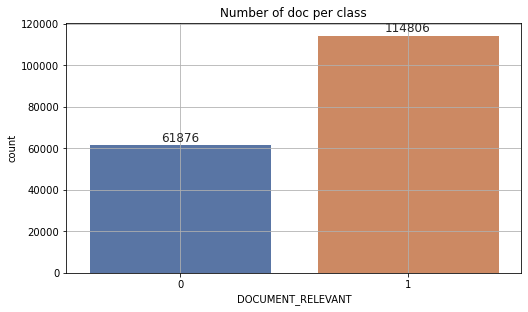

{1: 114806, 0: 61876}

In [14]:
# make a frequency plot for each category

category_counts = {}
for doc_type in df['DOCUMENT_RELEVANT']:
    if doc_type not in category_counts.keys():
        category_counts[doc_type] = 1
    else:
        category_counts[doc_type] += 1

plt.rcParams["figure.figsize"] = [7.50, 4.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
# df_train['DOCUMENT_CLASS'].value_counts().plot(ax=ax, kind='bar')

sns.set(style="ticks")
ax = sns.countplot(x='DOCUMENT_RELEVANT', data=df)
ax.bar_label(ax.containers[0])
plt.title("Number of doc per class")
plt.grid()
plt.show()
category_counts

In [15]:
# Clean data
def rm_non_ascii(text):
    # remeove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # remove digits and underscores
    text = re.sub(r'[0-9_:\-\'\"\[\]?/+=.,;!@#$%^&*()<>|{}~]+',' ', text)
    # removes mutiple spaces
    text = " ".join(text.split())
    return text

print("Sample X before cleaning:", dataX[1])
dataX = dataX.apply(str) # since some values are numbers only
dataX = dataX.apply(rm_non_ascii)
print("Sample X after cleaning:", dataX[1])


Sample X before cleaning: 1                       pls clear my account on
1    im having problems with the nike store app
Name: DOCUMENT_CONTENT, dtype: object
Sample X after cleaning: 1                       pls clear my account on
1    im having problems with the nike store app
Name: DOCUMENT_CONTENT, dtype: object


In [16]:
# Stemming and SW dont help!

# stemming to bring base word form. lemmatisation not req
def stemming(text):
    ps = PorterStemmer()

    words = word_tokenize(text)
    for i in range(len(words)):
        words[i] = ps.stem(words[i])
    text = " ".join(words)
    return text
        
print("Sample X before stemming:", dataX[1])
# dataX = dataX.apply(stemming)
print("Sample X after stemming:", dataX[1])



Sample X before stemming: 1                       pls clear my account on
1    im having problems with the nike store app
Name: DOCUMENT_CONTENT, dtype: object
Sample X after stemming: 1                       pls clear my account on
1    im having problems with the nike store app
Name: DOCUMENT_CONTENT, dtype: object


In [17]:
# Note:
# Do not remove SW, as they add new information(context-awareness) to the sentence (viz., text summarization, machine/language translation, language modeling, question-answering)
# Remove SW if we want only general idea of the sentence (viz., sentiment analysis, language/text classification, spam filtering, caption generation, auto-tag generation, topic/document

#loading the english language small model of spacy and removing from corpus
def remove_stop_words(text):
    words = [word for word in text.split() if word.lower() not in STOP_WORDS]
    new_text = " ".join(words)
    return new_text
        
print("Sample X before SW removal:", dataX[1])
# dataX = dataX.apply(remove_stop_words)
print("Sample X after SW removal:", dataX[1])


Sample X before SW removal: 1                       pls clear my account on
1    im having problems with the nike store app
Name: DOCUMENT_CONTENT, dtype: object
Sample X after SW removal: 1                       pls clear my account on
1    im having problems with the nike store app
Name: DOCUMENT_CONTENT, dtype: object


In [18]:
def show_metrics(y_test, y_pred, title="Classifier"):
    # Calculate confusion matrix

    matrix=confusion_matrix(y_test, y_pred)
    cm_labeled=pd.DataFrame(matrix,index=['0','1'],columns=['0','1'])
    # True Labels in y-axis/rows. Precision = TP/(TP+FP)
#     print("Confusion Matrix:\n", cm_labeled)
    sns.heatmap(cm_labeled, annot=True)
    plt.show()

    # Get the accuracy
    print('\nAccuracy: {:.6f}\n'.format(accuracy_score(y_test, y_pred)))

    # Print the classification report
    print(f'Classification Report {title}:')
#     TODO fix target names dynamic
    print(classification_report(y_test, y_pred, target_names=['relevant', 'non_relevant'],digits=6))
    return accuracy_score(y_test, y_pred)

In [19]:
# for getting refernce actual its relevant, but predicted non_relevant
reference_df = pd.DataFrame()
reference_df['DOCUMENT_CONTENT']=dataX
reference_df['DOCUMENT_CLASS']=df['DOCUMENT_CLASS']
reference_df['DOCUMENT_RELEVANT']=df['DOCUMENT_RELEVANT']

reference_df

,DOCUMENT_CONTENT,DOCUMENT_CLASS,DOCUMENT_RELEVANT
0,cant access my account,Account,1
1,pls clear my account on,Account,1
2,i cant access my account,Account,1
3,i cant get on my account,Account,1
4,why cant i have anaccount,Account,1
...,...,...,...
180930,A nice Easter vacation the resort is large lan...,*Variety*,1
180931,I have a reservation at the Hilton House in Ft...,*Variety*,1
180932,My husband and I enjoyed the salad bar buffet ...,*Variety*,1
180933,I went for lunch in the CAF The food was excel...,*Variety*,1


In [20]:
# X_train, X_test, y_train, y_test = train_test_split(reference_df, dataY, test_size=1 - train_ratio, random_state=42)

# X_train.to_csv('train_with_intent.csv')
# X_train

In [21]:
# Split data
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

print(X_train.shape, X_val.shape, X_test.shape)

(132511,) (26502,) (17669,)


In [22]:
# converting y into one hot vectors like multiclass

# encoded_dict = {‘0’:[1,0],’1’:[0,1]}
num_classes = len(category_counts.keys())
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [23]:
X_train = X_train.tolist()
X_val = X_val.values.tolist()
X_test = X_test.values.tolist()
print(len(X_train), type(X_train))


132511 <class 'list'>


### train_parameter variables

- model name change
- tokenizer max length = 200 (100-200)
- batch_szie = 128 (8, 32, 48, 128)
- training epochs = 4 (2-4)
- save folder name change 

In [24]:
# tokenizer converts sentence words into vector of fixed size numbers. Adding <Start> and <End> tag as well

max_length = 200
# TODO: or 200
# BERT tokenizer.
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# # XLNet tokenizer
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 
# # RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
# DistilBERT
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# MPNet
# tokenizer = MPNetTokenizer.from_pretrained("microsoft/mpnet-base")
# MiniLM
# tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-electra-base')
# DeBERTa
# tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
# DeBERTa v2
# tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v2-xlarge")
# Electra HF
# tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")
# Elctra Cross enocder
# tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-electra-base')
# DistilRoberta
# tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# tokenizer's encoding method
encodings_X_train = tokenizer.batch_encode_plus(X_train,max_length=max_length,pad_to_max_length=True, return_token_type_ids=True)
encodings_X_val = tokenizer.batch_encode_plus(X_val,max_length=max_length,pad_to_max_length=True, return_token_type_ids=True)
encodings_X_test = tokenizer.batch_encode_plus(X_test,max_length=max_length,pad_to_max_length=True, return_token_type_ids=True)

print('tokenizer outputs: ', encodings_X_train.keys())

loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [25]:
# train tokenized embeddings and masks
input_ids_X_train = encodings_X_train['input_ids'] # tokenized and encoded sentences
token_type_ids_X_train = encodings_X_train['token_type_ids'] # token type ids
attention_masks_X_train = encodings_X_train['attention_mask'] # attention masks

# validation tokenized embeddings and masks
input_ids_X_val = encodings_X_val['input_ids']
token_type_ids_X_val = encodings_X_val['token_type_ids'] 
attention_masks_X_val = encodings_X_val['attention_mask'] 

# test tokenized embeddings and masks
input_ids_X_test = encodings_X_test['input_ids']
token_type_ids_X_test = encodings_X_test['token_type_ids'] 
attention_masks_X_test = encodings_X_test['attention_mask']


print(f"{X_train[1]}  \n{y_train[1]} --->\n\ninput encoding : {input_ids_X_train[1]}\ntoken type ids : {token_type_ids_X_train[1]}\nattention mask : {attention_masks_X_train[1]}")

WestJet delays aren t cool Hi Thanks I have now phoned and only had to wait a few mins All sorted Scott that s nice and very good It certainly wasnt required Ian  
[1. 0.] --->

input encoding : [0, 9634, 21608, 6091, 2025, 326, 3035, 12289, 4557, 38, 33, 122, 7843, 11469, 8, 129, 56, 7, 2067, 10, 367, 27659, 404, 24713, 1699, 14, 579, 2579, 8, 182, 205, 85, 1819, 21, 3999, 1552, 5965, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
token type ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
# Select a batch size for training. For fine-tuning with XLNet, recommend a batch size of 8, 32, 48, 64 or 128.
batch_size = 64

# Convert all of our data into torch tensors
# train
input_ids_X_train = torch.tensor(input_ids_X_train)
attention_masks_X_train = torch.tensor(attention_masks_X_train)
y_train = torch.tensor(y_train)
token_type_ids_X_train = torch.tensor(token_type_ids_X_train)

# validation
input_ids_X_val = torch.tensor(input_ids_X_val)
attention_masks_X_val = torch.tensor(attention_masks_X_val)
y_val = torch.tensor(y_val)
token_type_ids_X_val = torch.tensor(token_type_ids_X_val)

# test
input_ids_X_test = torch.tensor(input_ids_X_test)
attention_masks_X_test = torch.tensor(attention_masks_X_test)
y_test = torch.tensor(y_test)
token_type_ids_X_test = torch.tensor(token_type_ids_X_test)


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, 
# unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(input_ids_X_train, attention_masks_X_train, y_train, token_type_ids_X_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(input_ids_X_val, attention_masks_X_val, y_val, token_type_ids_X_val)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create test dataloader
test_data = TensorDataset(input_ids_X_test, attention_masks_X_test, y_test, token_type_ids_X_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# save the dataloader
torch.save(train_dataloader,'train_data_loader')
torch.save(validation_dataloader,'validation_data_loader')
torch.save(test_dataloader,'test_data_loader')


In [27]:
# Load Model & Set Params
model_name = 'roberta-base'

# (batch_size, epoch, accuracy)
# BERT (128,20, 0.801)
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)
# XLNet: (32, 12, 0.799)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_classes)
# RoBERTa: (64, 32, 0.8001)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
# DistillBERT (128, 4, 0.998988)
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)
# MPNet (64,4,0.8033)
# model = MPNetForSequenceClassification.from_pretrained("microsoft/mpnet-base", num_labels=num_classes)
# MiniLM (48, 16, 0.8028)
# model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-MiniLM-L-12-v2',ignore_mismatched_sizes=True, num_labels=num_classes)
# deBERTa (32, 36, 0.8185)
# model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=num_classes)
# deBERTa v2
# model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v2-xlarge", num_labels=num_classes)
# Electra HF(128, 16, 0.8004)
# model = ElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion", ignore_mismatched_sizes=True, num_labels=num_classes)
# Electra Cross encoder (64, 16, 0.80889)
# model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-electra-base', ignore_mismatched_sizes=True, num_labels=num_classes)
# DistillRoberta
# model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_classes)

model.cuda()

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [28]:
# setting custom optimization parameters. may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
# print("named parameters: ", param_optimizer)
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [29]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True, )
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimizat

/root/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Train Model

In [30]:
import time
# use “Binary Cross Entropy With Logits” as our loss function

# Store our loss and accuracy for plotting
train_loss_set = [] # loss per training batch
train_history = [] # [train_loss, val_f1_accuracy, val_flat_accuracy, epoch_time]

In [31]:


# Number of training epochs (recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training start
  s_time = time.time()
    
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_classes),b_labels.type_as(logits).view(-1,num_classes)) #convert labels to float for calculation
#     loss_func = BCELoss() 
#     loss_func = CrossEntropyLoss() 
#     loss = loss_func(torch.sigmoid(logits.view(-1,num_classes)),b_labels.type_as(logits).view(-1,num_classes)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
#   pred_bools = [pl>threshold for pl in pred_labels]
#   true_bools = [tl==1 for tl in true_labels]
  pred_bools = [np.argmax(pl, axis=0) for pl in pred_labels]    
  true_bools = [np.argmax(pl, axis=0) for pl in true_labels]

  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

  e_time = time.time()
  # Populate history
  train_history.append([tr_loss/nb_tr_steps, val_f1_accuracy, val_flat_accuracy, e_time-s_time])

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4693538335384464


Epoch:  25%|██▌       | 1/4 [26:11<1:18:33, 1571.01s/it]

F1 Validation Accuracy:  80.18640102633763
Flat Validation Accuracy:  80.18640102633763
Train loss: 0.38546395873833483


Epoch:  50%|█████     | 2/4 [52:23<52:24, 1572.14s/it]  

F1 Validation Accuracy:  80.55995773903857
Flat Validation Accuracy:  80.55995773903857
Train loss: 0.34418597876421214


Epoch:  75%|███████▌  | 3/4 [1:18:37<26:12, 1572.81s/it]

F1 Validation Accuracy:  80.83918194853219
Flat Validation Accuracy:  80.83918194853219
Train loss: 0.3122543767274491


Epoch: 100%|██████████| 4/4 [1:44:49<00:00, 1572.40s/it]

F1 Validation Accuracy:  80.01660252056449
Flat Validation Accuracy:  80.01660252056449


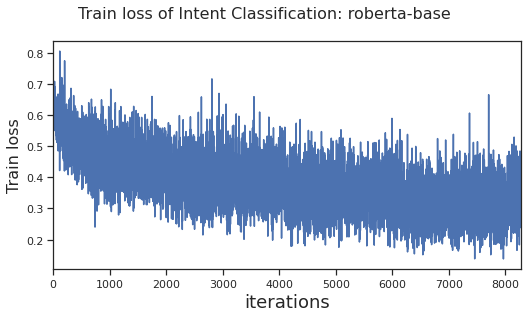

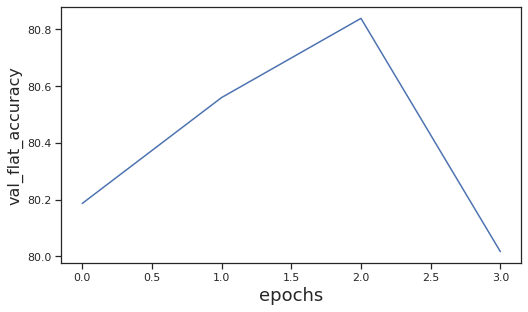

,train_loss,val_f1_accuracy,val_flat_accuracy,epoch_time
0,0.469354,80.186401,80.186401,1571.010979
1,0.385464,80.559958,80.559958,1572.937610
2,0.344186,80.839182,80.839182,1573.599563
3,0.312254,80.016603,80.016603,1572.063714


In [32]:
train_history_df = pd.DataFrame(train_history, columns =['train_loss', 'val_f1_accuracy', 'val_flat_accuracy', 'epoch_time']) 
train_loss_all_df = pd.DataFrame(train_loss_set, columns =['train_loss_batch'])
train_loss_all_df

# plot and train loss & visualize over batch
fig,ax = plt.subplots(1,1)
ax.margins(x=0)
fig.suptitle('Train loss of Intent Classification: '+model_name, fontsize=16)
plt.xlabel('iterations', fontsize=18)
plt.ylabel('Train loss', fontsize=16);
a,_ = plt.xticks();
plt.plot(np.arange(len(train_loss_set)), train_loss_set)
plt.show()

fig.suptitle('Accuracy of Intent Classification: '+model_name, fontsize=16)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('val_flat_accuracy', fontsize=16);
plt.plot(np.arange(len(train_history_df['val_flat_accuracy'])), train_history_df['val_flat_accuracy'])
plt.show()

train_history_df


### Test Model and Get Metrics

In [33]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds, true_labels, pred_labels, tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]


Test F1 Accuracy:  0.8006678363235044
Test Flat Accuracy:  0.8006678363235045 



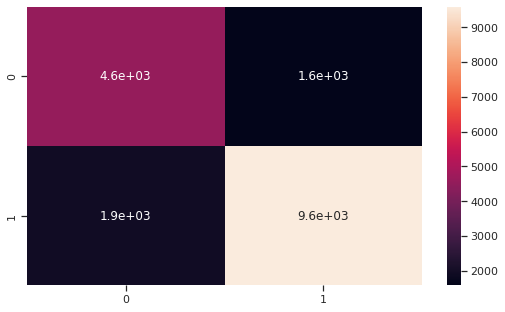


Accuracy: 0.800668

Classification Report Classifier:
              precision    recall  f1-score   support

    relevant   0.700907  0.742950  0.721317      6135
non_relevant   0.858768  0.831368  0.844846     11534

    accuracy                       0.800668     17669
   macro avg   0.779837  0.787159  0.783081     17669
weighted avg   0.803956  0.800668  0.801954     17669



,precision,recall,f1-score,support
relevant,0.700907,0.742950,0.721317,6135.000000
non_relevant,0.858768,0.831368,0.844846,11534.000000
accuracy,0.800668,0.800668,0.800668,0.800668
macro avg,0.779837,0.787159,0.783081,17669.000000
weighted avg,0.803956,0.800668,0.801954,17669.000000


In [34]:
# Converting flattened binary values to boolean values
# true_bools = [tl==1 for tl in true_labels]
# pred_bools = [pl>0.60 for pl in pred_labels] #boolean output after thresholding

# get back single value labels from one-hot encoding
y_pred = [np.argmax(pl, axis=0) for pl in pred_labels]
y_testl = [np.argmax(pl, axis=0) for pl in true_labels]

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(y_testl, y_pred,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(y_testl, y_pred),'\n')
clf_report = classification_report(y_testl,y_pred,target_names=['relevant','non_relevant'], digits=10, output_dict=True)
show_metrics(y_testl, y_pred)

# pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
clf_df = pd.DataFrame(clf_report).transpose()
clf_df

In [35]:
stopp

NameError: name 'stopp' is not defined

In [ ]:
# Save Model

# Change dir path only
output_dir = os.path.join(ROOT, "model_save/",model_name)
os.makedirs(output_dir, exist_ok=True)

model_weight_path = os.path.join(output_dir, 'model_weight')
model_path = os.path.join(output_dir, 'model.pt')
report_path = os.path.join(output_dir, 'classification_report.csv')
train_history_path = os.path.join(output_dir, 'train_history.csv')
train_loss_all = os.path.join(output_dir, 'train_loss_all.csv')

## for loading back
# model = model_class.from_pretrained(output_dir)
# # load your model architecture/module
# model = YourModel()
# # fill your architecture with the trained weights
# model.load_state_dict(torch.load("output_dir.pt"))
# # or complete model
# the_model = torch.load(output_dir)

# save the weights and the model to a .pt file
torch.save(model.state_dict(), model_weight_path)
torch.save(model, model_path)

# save report
train_history_df.to_csv(train_history_path)
train_loss_all_df.to_csv(train_loss_all)
clf_df.to_csv(report_path)
print(f"Saved to {output_dir}")


## Getting counter of miss predictions. 
Return old_category of Relevant labels predicted as non_relevant

In [ ]:

# Relevant true jisko non-relevant predict Kiya vo konse message h. Find their old category
# y_actual=1, y_pred=0
bad_relevant_pred = [msg1==1 and msg2==0 for msg1, msg2 in zip(y_testl, y_pred)]
print("bad_relevant_pred size: ", len(bad_relevant_pred))
# map (x,y) to reference_df[x]
bad_X = [val for is_correct, val in zip(bad_relevant_pred, X_test) if is_correct]
print("miss len: ", len(bad_X))

# df.loc(X_test[0])
bad_rows = reference_df.loc[reference_df['DOCUMENT_CONTENT'].isin(bad_X)]
old_category_list = np.sort(list(bad_rows['DOCUMENT_CLASS']))

# cnt old_category_list > bad_X due to DOCUMENT_CONTENT non unique
print(len(old_category_list))
old_category_list
from collections import Counter
bad_counter = Counter(old_category_list) 
# print(bad_counter)

counter_df = pd.DataFrame()
counter_df['DOCUMENT_CLASS'] = bad_counter.keys()
counter_df['MISS_COUNT'] = bad_counter.values()

# save
bad_counter_path = os.path.join(output_dir, 'miss_count')
counter_df.to_csv(bad_counter_path)
counter_df




In [ ]:
class imbalance
last 5 category taken as relvant by me